<a href="https://colab.research.google.com/github/shikharsrivastava23/Tensorflow_tut/blob/master/Autoencoders_task.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Denoising Autoencoders And Where To Find Them

Today we're going to train deep autoencoders and apply them to faces and similar images search.

Our new test subjects are human faces from the [lfw dataset](http://vis-www.cs.umass.edu/lfw/).

# Import stuff

In [1]:
! shred -u setup_google_colab.py
! wget https://raw.githubusercontent.com/hse-aml/intro-to-dl/master/setup_google_colab.py -O setup_google_colab.py
import setup_google_colab
# please, uncomment the week you're working on
# setup_google_colab.setup_week1()
# setup_google_colab.setup_week2()
# setup_google_colab.setup_week3()
setup_google_colab.setup_week4()
# setup_google_colab.setup_week5()
# setup_google_colab.setup_week6()

# If you're using the old version of the course (check a path of notebook on Coursera, you'll see v1 or v2),
# use setup_week2_old().

shred: setup_google_colab.py: failed to open for writing: No such file or directory
--2019-08-05 14:10:16--  https://raw.githubusercontent.com/hse-aml/intro-to-dl/master/setup_google_colab.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3792 (3.7K) [text/plain]
Saving to: ‘setup_google_colab.py’

setup_google_colab. 100%[===================>]   3.70K  --.-KB/s    in 0s      

2019-08-05 14:10:16 (51.6 MB/s) - ‘setup_google_colab.py’ saved [3792/3792]

**************************************************
lfw-deepfunneled.tgz
**************************************************
lfw.tgz
**************************************************
lfw_attributes.txt


In [0]:
import sys
sys.path.append("..")
import grading

In [3]:
import tensorflow as tf
import keras, keras.layers as L, keras.backend as K
import numpy as np
from sklearn.model_selection import train_test_split
from lfw_dataset import load_lfw_dataset
%matplotlib inline
import matplotlib.pyplot as plt
import download_utils
import keras_utils
import numpy as np
from keras_utils import reset_tf_session

Using TensorFlow backend.


In [0]:
# !!! remember to clear session/graph if you rebuild your graph to avoid out-of-memory errors !!!

# Load dataset
Dataset was downloaded for you. Relevant links (just in case):
- http://www.cs.columbia.edu/CAVE/databases/pubfig/download/lfw_attributes.txt
- http://vis-www.cs.umass.edu/lfw/lfw-deepfunneled.tgz
- http://vis-www.cs.umass.edu/lfw/lfw.tgz

In [0]:
# we downloaded them for you, just link them here
download_utils.link_week_4_resources()

In [6]:
# load images
X, attr = load_lfw_dataset(use_raw=True, dimx=32, dimy=32)
IMG_SHAPE = X.shape[1:]

# center images
X = X.astype('float32') / 255.0 - 0.5

# split
X_train, X_test = train_test_split(X, test_size=0.1, random_state=42)

**************************************************



In [0]:
def show_image(x):
    plt.imshow(np.clip(x + 0.5, 0, 1))

X shape: (13143, 32, 32, 3)
attr shape: (13143, 73)


1029

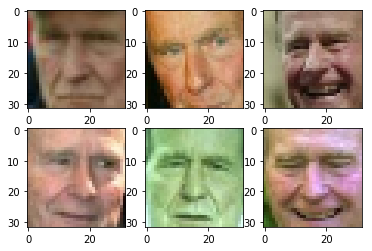

In [8]:
plt.title('sample images')

for i in range(6):
    plt.subplot(2,3,i+1)
    show_image(X[i])

print("X shape:", X.shape)
print("attr shape:", attr.shape)

# try to free memory
del X
import gc
gc.collect()

# Autoencoder architecture

Let's design autoencoder as two sequential keras models: the encoder and decoder respectively.

We will then use symbolic API to apply and train these models.

<img src="https://github.com/hse-aml/intro-to-dl/blob/master/week4/images/autoencoder.png?raw=1" style="width:50%">

# First step: PCA

Principial Component Analysis is a popular dimensionality reduction method. 

Under the hood, PCA attempts to decompose object-feature matrix $X$ into two smaller matrices: $W$ and $\hat W$ minimizing _mean squared error_:

$$\|(X W) \hat{W} - X\|^2_2 \to_{W, \hat{W}} \min$$
- $X \in \mathbb{R}^{n \times m}$ - object matrix (**centered**);
- $W \in \mathbb{R}^{m \times d}$ - matrix of direct transformation;
- $\hat{W} \in \mathbb{R}^{d \times m}$ - matrix of reverse transformation;
- $n$ samples, $m$ original dimensions and $d$ target dimensions;

In geometric terms, we want to find d axes along which most of variance occurs. The "natural" axes, if you wish.

<img src="https://github.com/hse-aml/intro-to-dl/blob/master/week4/images/pca.png?raw=1" style="width:30%">


PCA can also be seen as a special case of an autoencoder.

* __Encoder__: X -> Dense(d units) -> code
* __Decoder__: code -> Dense(m units) -> X

Where Dense is a fully-connected layer with linear activaton:   $f(X) = W \cdot X + \vec b $


Note: the bias term in those layers is responsible for "centering" the matrix i.e. substracting mean.

In [0]:
def build_pca_autoencoder(img_shape, code_size):
    """
    Here we define a simple linear autoencoder as described above.
    We also flatten and un-flatten data to be compatible with image shapes
    """
    
    encoder = keras.models.Sequential()
    encoder.add(L.InputLayer(img_shape))
    encoder.add(L.Flatten())                  #flatten image to vector
    encoder.add(L.Dense(code_size))           #actual encoder

    decoder = keras.models.Sequential()
    decoder.add(L.InputLayer((code_size,)))
    decoder.add(L.Dense(np.prod(img_shape)))  #actual decoder, height*width*3 units
    decoder.add(L.Reshape(img_shape))         #un-flatten
    
    return encoder,decoder

Meld them together into one model:

In [10]:
s = reset_tf_session()

encoder, decoder = build_pca_autoencoder(IMG_SHAPE, code_size=32)

inp = L.Input(IMG_SHAPE)
code = encoder(inp)
reconstruction = decoder(code)

autoencoder = keras.models.Model(inputs=inp, outputs=reconstruction)
autoencoder.compile(optimizer='adamax', loss='mse')

autoencoder.fit(x=X_train, y=X_train, epochs=15,
                validation_data=[X_test, X_test],
                callbacks=[keras_utils.TqdmProgressCallback()],
                verbose=0)

W0805 14:12:12.386265 140545424512896 deprecation_wrapper.py:119] From /content/keras_utils.py:68: The name tf.get_default_session is deprecated. Please use tf.compat.v1.get_default_session instead.

W0805 14:12:12.388325 140545424512896 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:79: The name tf.reset_default_graph is deprecated. Please use tf.compat.v1.reset_default_graph instead.

W0805 14:12:12.389154 140545424512896 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:82: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0805 14:12:12.405790 140545424512896 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:84: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0805 14:12:12.406749 140545424512896 deprecation_wrapper.py:119] F


Epoch 1/15
**************************************************
loss: 0.0124; val_loss: 0.0085

Epoch 2/15
**************************************************
loss: 0.0077; val_loss: 0.0070

Epoch 3/15
**************************************************
loss: 0.0069; val_loss: 0.0067

Epoch 4/15
**************************************************
loss: 0.0067; val_loss: 0.0067

Epoch 5/15
**************************************************
loss: 0.0067; val_loss: 0.0066

Epoch 6/15
**************************************************
loss: 0.0067; val_loss: 0.0067

Epoch 7/15
**************************************************
loss: 0.0067; val_loss: 0.0066

Epoch 8/15
**************************************************
loss: 0.0067; val_loss: 0.0066

Epoch 9/15
**************************************************
loss: 0.0067; val_loss: 0.0066

Epoch 10/15
**************************************************
loss: 0.0067; val_loss: 0.0066

Epoch 11/15
**********************************************

In [0]:
def visualize(img,encoder,decoder):
    """Draws original, encoded and decoded images"""
    code = encoder.predict(img[None])[0]  # img[None] is the same as img[np.newaxis, :]
    reco = decoder.predict(code[None])[0]

    plt.subplot(1,3,1)
    plt.title("Original")
    show_image(img)

    plt.subplot(1,3,2)
    plt.title("Code")
    plt.imshow(code.reshape([code.shape[-1]//2,-1]))

    plt.subplot(1,3,3)
    plt.title("Reconstructed")
    show_image(reco)
    plt.show()


PCA MSE: 0.0065971599477467205


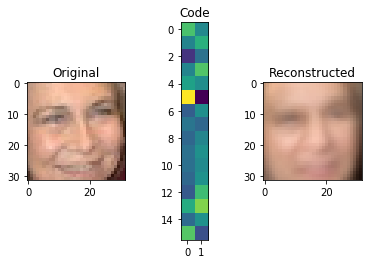

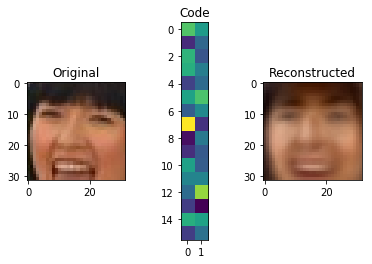

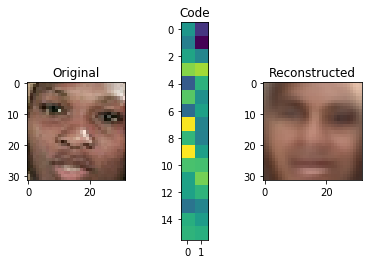

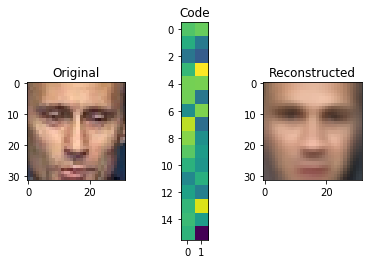

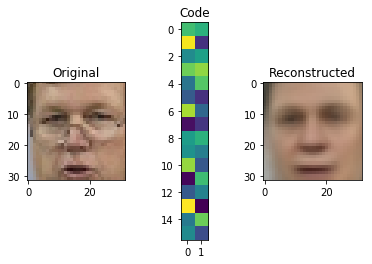

In [12]:
score = autoencoder.evaluate(X_test,X_test,verbose=0)
print("PCA MSE:", score)

for i in range(5):
    img = X_test[i]
    visualize(img,encoder,decoder)

# Going deeper: convolutional autoencoder

PCA is neat but surely we can do better. This time we want you to build a deep convolutional autoencoder by... stacking more layers.

## Encoder

The **encoder** part is pretty standard, we stack convolutional and pooling layers and finish with a dense layer to get the representation of desirable size (`code_size`).

We recommend to use `activation='elu'` for all convolutional and dense layers.

We recommend to repeat (conv, pool) 4 times with kernel size (3, 3), `padding='same'` and the following numbers of output channels: `32, 64, 128, 256`.

Remember to flatten (`L.Flatten()`) output before adding the last dense layer!

## Decoder

For **decoder** we will use so-called "transpose convolution". 

Traditional convolutional layer takes a patch of an image and produces a number (patch -> number). In "transpose convolution" we want to take a number and produce a patch of an image (number -> patch). We need this layer to "undo" convolutions in encoder. We had a glimpse of it during week 3 (watch [this video](https://www.coursera.org/learn/intro-to-deep-learning/lecture/auRqf/a-glimpse-of-other-computer-vision-tasks) starting at 5:41).

Here's how "transpose convolution" works:
<img src="https://github.com/hse-aml/intro-to-dl/blob/master/week4/images/transpose_conv.jpg?raw=1" style="width:60%">
In this example we use a stride of 2 to produce 4x4 output, this way we "undo" pooling as well. Another way to think about it: we "undo" convolution with stride 2 (which is similar to conv + pool).

You can add "transpose convolution" layer in Keras like this:
```python
L.Conv2DTranspose(filters=?, kernel_size=(3, 3), strides=2, activation='elu', padding='same')
```

Our decoder starts with a dense layer to "undo" the last layer of encoder. Remember to reshape its output to "undo" `L.Flatten()` in encoder.

Now we're ready to undo (conv, pool) pairs. For this we need to stack 4 `L.Conv2DTranspose` layers with the following numbers of output channels: `128, 64, 32, 3`. Each of these layers will learn to "undo" (conv, pool) pair in encoder. For the last `L.Conv2DTranspose` layer use `activation=None` because that is our final image.

In [13]:
# Let's play around with transpose convolution on examples first
def test_conv2d_transpose(img_size, filter_size):
    print("Transpose convolution test for img_size={}, filter_size={}:".format(img_size, filter_size))
    
    x = (np.arange(img_size ** 2, dtype=np.float32) + 1).reshape((1, img_size, img_size, 1))
    f = (np.ones(filter_size ** 2, dtype=np.float32)).reshape((filter_size, filter_size, 1, 1))

    s = reset_tf_session()
    
    conv = tf.nn.conv2d_transpose(x, f, 
                                  output_shape=(1, img_size * 2, img_size * 2, 1), 
                                  strides=[1, 2, 2, 1], 
                                  padding='SAME')

    result = s.run(conv)
    print("input:")
    print(x[0, :, :, 0])
    print("filter:")
    print(f[:, :, 0, 0])
    print("output:")
    print(result[0, :, :, 0])
    s.close()
        
test_conv2d_transpose(img_size=2, filter_size=2)
test_conv2d_transpose(img_size=2, filter_size=3)
test_conv2d_transpose(img_size=4, filter_size=2)
test_conv2d_transpose(img_size=4, filter_size=3)

Transpose convolution test for img_size=2, filter_size=2:
input:
[[1. 2.]
 [3. 4.]]
filter:
[[1. 1.]
 [1. 1.]]
output:
[[1. 1. 2. 2.]
 [1. 1. 2. 2.]
 [3. 3. 4. 4.]
 [3. 3. 4. 4.]]
Transpose convolution test for img_size=2, filter_size=3:
input:
[[1. 2.]
 [3. 4.]]
filter:
[[1. 1. 1.]
 [1. 1. 1.]
 [1. 1. 1.]]
output:
[[ 1.  1.  3.  2.]
 [ 1.  1.  3.  2.]
 [ 4.  4. 10.  6.]
 [ 3.  3.  7.  4.]]
Transpose convolution test for img_size=4, filter_size=2:
input:
[[ 1.  2.  3.  4.]
 [ 5.  6.  7.  8.]
 [ 9. 10. 11. 12.]
 [13. 14. 15. 16.]]
filter:
[[1. 1.]
 [1. 1.]]
output:
[[ 1.  1.  2.  2.  3.  3.  4.  4.]
 [ 1.  1.  2.  2.  3.  3.  4.  4.]
 [ 5.  5.  6.  6.  7.  7.  8.  8.]
 [ 5.  5.  6.  6.  7.  7.  8.  8.]
 [ 9.  9. 10. 10. 11. 11. 12. 12.]
 [ 9.  9. 10. 10. 11. 11. 12. 12.]
 [13. 13. 14. 14. 15. 15. 16. 16.]
 [13. 13. 14. 14. 15. 15. 16. 16.]]
Transpose convolution test for img_size=4, filter_size=3:
input:
[[ 1.  2.  3.  4.]
 [ 5.  6.  7.  8.]
 [ 9. 10. 11. 12.]
 [13. 14. 15. 16.]]
filter

In [0]:
def build_deep_autoencoder(img_shape, code_size):
    """PCA's deeper brother. See instructions above. Use `code_size` in layer definitions."""
    H,W,C = img_shape
    
    # encoder
    encoder = keras.models.Sequential()
    encoder.add(L.InputLayer(img_shape))
    
    ### YOUR CODE HERE: define encoder as per instructions above ###
    encoder.add(L.Conv2D(32, kernel_size=(3, 3), padding='same', activation='elu'))
    encoder.add(L.MaxPooling2D(pool_size=(2, 2), padding='same'))
    encoder.add(L.Conv2D(64, kernel_size=(3, 3), padding='same', activation='elu'))
    encoder.add(L.MaxPooling2D(pool_size=(2, 2), padding='same'))
    encoder.add(L.Conv2D(128, kernel_size=(3, 3), padding='same', activation='elu'))
    encoder.add(L.MaxPooling2D(pool_size=(2, 2), padding='same'))
    encoder.add(L.Conv2D(256, kernel_size=(3, 3), padding='same', activation='elu'))
    encoder.add(L.MaxPooling2D(pool_size=(2, 2), padding='same'))
    encoder.add(L.Flatten())                  
    encoder.add(L.Dense(code_size))

    # decoder
    decoder = keras.models.Sequential()
    decoder.add(L.InputLayer((code_size,)))
    
    ### YOUR CODE HERE: define decoder as per instructions above ###
    decoder.add(L.Dense(2*2*256))
    decoder.add(L.Reshape((2,2,256)))
    decoder.add(L.Conv2DTranspose(filters=128, kernel_size=(3, 3), strides=2, activation='elu', padding='same'))
    decoder.add(L.Conv2DTranspose(filters=64, kernel_size=(3, 3), strides=2, activation='elu', padding='same'))
    decoder.add(L.Conv2DTranspose(filters=32, kernel_size=(3, 3), strides=2, activation='elu', padding='same'))
    decoder.add(L.Conv2DTranspose(filters=3, kernel_size=(3, 3), strides=2, activation=None, padding='same'))
    
    return encoder, decoder

In [15]:
# Check autoencoder shapes along different code_sizes
get_dim = lambda layer: np.prod(layer.output_shape[1:])
for code_size in [1,8,32,128,512]:
    s = reset_tf_session()
    encoder, decoder = build_deep_autoencoder(IMG_SHAPE, code_size=code_size)
    print("Testing code size %i" % code_size)
    assert encoder.output_shape[1:]==(code_size,),"encoder must output a code of required size"
    assert decoder.output_shape[1:]==IMG_SHAPE,   "decoder must output an image of valid shape"
    assert len(encoder.trainable_weights)>=6,     "encoder must contain at least 3 layers"
    assert len(decoder.trainable_weights)>=6,     "decoder must contain at least 3 layers"
    
    for layer in encoder.layers + decoder.layers:
        assert get_dim(layer) >= code_size, "Encoder layer %s is smaller than bottleneck (%i units)"%(layer.name,get_dim(layer))

print("All tests passed!")
s = reset_tf_session()

W0805 14:20:48.346272 140545424512896 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:3378: The name tf.nn.max_pool is deprecated. Please use tf.nn.max_pool2d instead.



Testing code size 1
Testing code size 8
Testing code size 32
Testing code size 128
Testing code size 512
All tests passed!


In [16]:
# Look at encoder and decoder shapes.
# Total number of trainable parameters of encoder and decoder should be close.
s = reset_tf_session()
encoder, decoder = build_deep_autoencoder(IMG_SHAPE, code_size=32)
encoder.summary()
decoder.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 32, 32, 3)         0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 32, 32, 32)        896       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 16, 16, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 16, 16, 64)        18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 8, 8, 64)          0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 8, 8, 128)         73856     
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 4, 4, 128)         0         
__________

Convolutional autoencoder training. This will take **1 hour**. You're aiming at ~0.0056 validation MSE and ~0.0054 training MSE.

In [0]:
s = reset_tf_session()

encoder, decoder = build_deep_autoencoder(IMG_SHAPE, code_size=32)

inp = L.Input(IMG_SHAPE)
code = encoder(inp)
reconstruction = decoder(code)

autoencoder = keras.models.Model(inputs=inp, outputs=reconstruction)
autoencoder.compile(optimizer="adamax", loss='mse')

In [0]:
# we will save model checkpoints here to continue training in case of kernel death
model_filename = 'autoencoder.{0:03d}.hdf5'
last_finished_epoch = None

#### uncomment below to continue training from model checkpoint
#### fill `last_finished_epoch` with your latest finished epoch
# from keras.models import load_model
# s = reset_tf_session()
# last_finished_epoch = 4
# autoencoder = load_model(model_filename.format(last_finished_epoch))
# encoder = autoencoder.layers[1]
# decoder = autoencoder.layers[2]

In [19]:
autoencoder.fit(x=X_train, y=X_train, epochs=25,
                validation_data=[X_test, X_test],
                callbacks=[keras_utils.ModelSaveCallback(model_filename),
                           keras_utils.TqdmProgressCallback()],
                verbose=0,
                initial_epoch=last_finished_epoch or 0)


Epoch 1/25
**************************************************Model saved in autoencoder.000.hdf5

loss: 0.0122; val_loss: 0.0082

Epoch 2/25
**************************************************Model saved in autoencoder.001.hdf5

loss: 0.0076; val_loss: 0.0072

Epoch 3/25
**************************************************Model saved in autoencoder.002.hdf5

loss: 0.0071; val_loss: 0.0069

Epoch 4/25
**************************************************Model saved in autoencoder.003.hdf5

loss: 0.0069; val_loss: 0.0068

Epoch 5/25
**************************************************Model saved in autoencoder.004.hdf5

loss: 0.0068; val_loss: 0.0067

Epoch 6/25
**************************************************Model saved in autoencoder.005.hdf5

loss: 0.0067; val_loss: 0.0067

Epoch 7/25
**************************************************Model saved in autoencoder.006.hdf5

loss: 0.0066; val_loss: 0.0065

Epoch 8/25
**************************************************Model saved in autoencoder.0

Convolutional autoencoder MSE: 0.005486778104182036


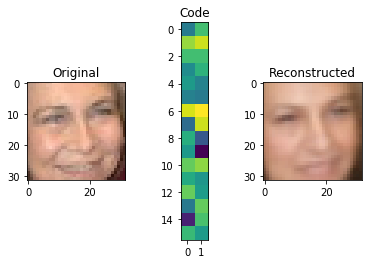

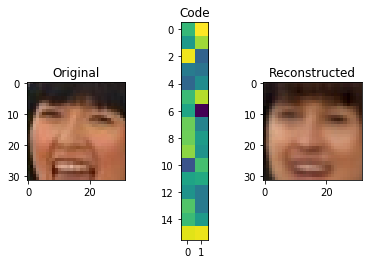

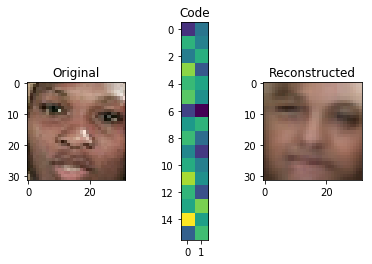

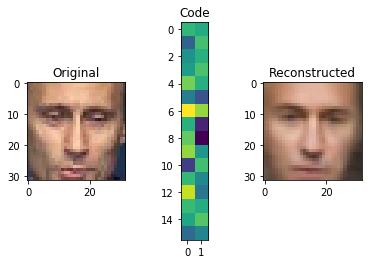

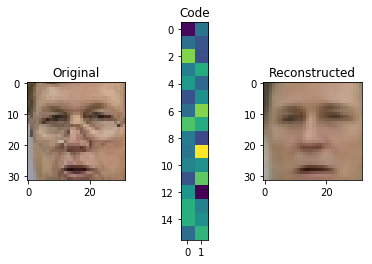

In [20]:
reconstruction_mse = autoencoder.evaluate(X_test, X_test, verbose=0)
print("Convolutional autoencoder MSE:", reconstruction_mse)
for i in range(5):
    img = X_test[i]
    visualize(img,encoder,decoder)

In [0]:
# save trained weights
encoder.save_weights("encoder.h5")
decoder.save_weights("decoder.h5")

In [22]:
# restore trained weights
s = reset_tf_session()

encoder, decoder = build_deep_autoencoder(IMG_SHAPE, code_size=32)
encoder.load_weights("encoder.h5")
decoder.load_weights("decoder.h5")

inp = L.Input(IMG_SHAPE)
code = encoder(inp)
reconstruction = decoder(code)

autoencoder = keras.models.Model(inputs=inp, outputs=reconstruction)
autoencoder.compile(optimizer="adamax", loss='mse')

print(autoencoder.evaluate(X_test, X_test, verbose=0))
print(reconstruction_mse)

0.0054867781144513714
0.005486778104182036


# Submit to Coursera

In [23]:
from submit import submit_autoencoder
submission = build_deep_autoencoder(IMG_SHAPE, code_size=71)

# token expires every 30 min
COURSERA_TOKEN = "GXN80IsxlqroKDc8" ### YOUR TOKEN HERE
COURSERA_EMAIL = "shikharsrivastava234@gmail.com" ### YOUR EMAIL HERE

submit_autoencoder(submission, reconstruction_mse, COURSERA_EMAIL, COURSERA_TOKEN)

Submitted to Coursera platform. See results on assignment page!


# Optional: Denoising Autoencoder

This part is **optional**, it shows you one useful application of autoencoders: denoising. You can run this code and make sure denoising works :) 

Let's now turn our model into a denoising autoencoder:
<img src="https://github.com/hse-aml/intro-to-dl/blob/master/week4/images/denoising.jpg?raw=1" style="width:40%">

We'll keep the model architecture, but change the way it is trained. In particular, we'll corrupt its input data randomly with noise before each epoch.

There are many strategies to introduce noise: adding gaussian white noise, occluding with random black rectangles, etc. We will add gaussian white noise.

In [0]:
def apply_gaussian_noise(X,sigma=0.1):
    """
    adds noise from standard normal distribution with standard deviation sigma
    :param X: image tensor of shape [batch,height,width,3]
    Returns X + noise.
    """
    noise = np.random.normal(loc=0., scale=sigma, size=X.shape) ### YOUR CODE HERE ###
    return X + noise

In [0]:
# noise tests
theoretical_std = (X_train[:100].std()**2 + 0.5**2)**.5
our_std = apply_gaussian_noise(X_train[:100],sigma=0.5).std()
assert abs(theoretical_std - our_std) < 0.01, "Standard deviation does not match it's required value. Make sure you use sigma as std."
assert abs(apply_gaussian_noise(X_train[:100],sigma=0.5).mean() - X_train[:100].mean()) < 0.01, "Mean has changed. Please add zero-mean noise"

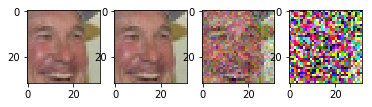

In [26]:
# test different noise scales
plt.subplot(1,4,1)
show_image(X_train[0])
plt.subplot(1,4,2)
show_image(apply_gaussian_noise(X_train[:1],sigma=0.01)[0])
plt.subplot(1,4,3)
show_image(apply_gaussian_noise(X_train[:1],sigma=0.1)[0])
plt.subplot(1,4,4)
show_image(apply_gaussian_noise(X_train[:1],sigma=0.5)[0])

Training will take **1 hour**.

In [27]:
s = reset_tf_session()

# we use bigger code size here for better quality
encoder, decoder = build_deep_autoencoder(IMG_SHAPE, code_size=512)
assert encoder.output_shape[1:]==(512,), "encoder must output a code of required size"

inp = L.Input(IMG_SHAPE)
code = encoder(inp)
reconstruction = decoder(code)

autoencoder = keras.models.Model(inp, reconstruction)
autoencoder.compile('adamax', 'mse')

for i in range(25):
    print("Epoch %i/25, Generating corrupted samples..."%(i+1))
    X_train_noise = apply_gaussian_noise(X_train)
    X_test_noise = apply_gaussian_noise(X_test)
    
    # we continue to train our model with new noise-augmented data
    autoencoder.fit(x=X_train_noise, y=X_train, epochs=1,
                    validation_data=[X_test_noise, X_test],
                    callbacks=[keras_utils.TqdmProgressCallback()],
                    verbose=0)

Epoch 1/25, Generating corrupted samples...

Epoch 1/1
**************************************************
loss: 0.0109; val_loss: 0.0072
Epoch 2/25, Generating corrupted samples...

Epoch 1/1
**************************************************
loss: 0.0064; val_loss: 0.0058
Epoch 3/25, Generating corrupted samples...

Epoch 1/1
**************************************************
loss: 0.0054; val_loss: 0.0050
Epoch 4/25, Generating corrupted samples...

Epoch 1/1
**************************************************
loss: 0.0048; val_loss: 0.0046
Epoch 5/25, Generating corrupted samples...

Epoch 1/1
**************************************************
loss: 0.0044; val_loss: 0.0042
Epoch 6/25, Generating corrupted samples...

Epoch 1/1
**************************************************
loss: 0.0041; val_loss: 0.0041
Epoch 7/25, Generating corrupted samples...

Epoch 1/1
**************************************************
loss: 0.0039; val_loss: 0.0039
Epoch 8/25, Generating corrupted samples.

Denoising MSE: 0.002756387417509217


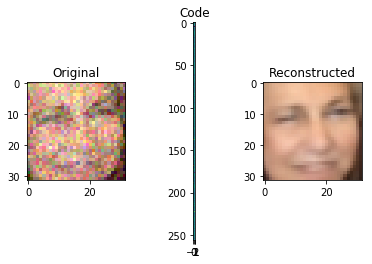

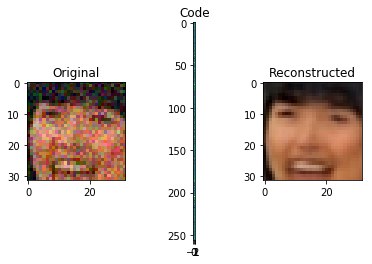

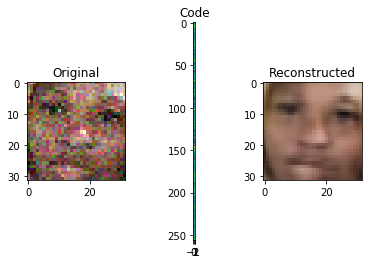

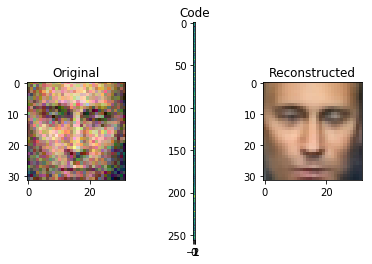

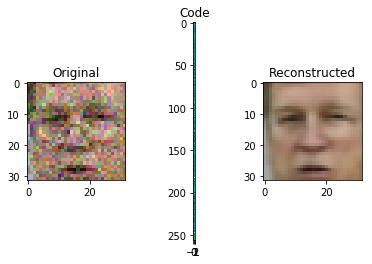

In [28]:
X_test_noise = apply_gaussian_noise(X_test)
denoising_mse = autoencoder.evaluate(X_test_noise, X_test, verbose=0)
print("Denoising MSE:", denoising_mse)
for i in range(5):
    img = X_test_noise[i]
    visualize(img,encoder,decoder)

# Optional: Image retrieval with autoencoders

So we've just trained a network that converts image into itself imperfectly. This task is not that useful in and of itself, but it has a number of awesome side-effects. Let's see them in action.

First thing we can do is image retrieval aka image search. We will give it an image and find similar images in latent space:

<img src="https://github.com/hse-aml/intro-to-dl/blob/master/week4/images/similar_images.jpg?raw=1" style="width:60%">

To speed up retrieval process, one should use Locality Sensitive Hashing on top of encoded vectors. This [technique](https://erikbern.com/2015/07/04/benchmark-of-approximate-nearest-neighbor-libraries.html) can narrow down the potential nearest neighbours of our image in latent space (encoder code). We will caclulate nearest neighbours in brute force way for simplicity.

In [0]:
# restore trained encoder weights
s = reset_tf_session()
encoder, decoder = build_deep_autoencoder(IMG_SHAPE, code_size=32)
encoder.load_weights("encoder.h5")

In [0]:
images = X_train
codes = encoder.predict(images) ### YOUR CODE HERE: encode all images ###
assert len(codes) == len(images)

In [31]:
from sklearn.neighbors.unsupervised import NearestNeighbors
nei_clf = NearestNeighbors(metric="euclidean")
nei_clf.fit(codes)

NearestNeighbors(algorithm='auto', leaf_size=30, metric='euclidean',
                 metric_params=None, n_jobs=None, n_neighbors=5, p=2,
                 radius=1.0)

In [0]:
def get_similar(image, n_neighbors=5):
    assert image.ndim==3,"image must be [batch,height,width,3]"

    code = encoder.predict(image[None])
    
    (distances,),(idx,) = nei_clf.kneighbors(code,n_neighbors=n_neighbors)
    
    return distances,images[idx]

In [0]:
def show_similar(image):
    
    distances,neighbors = get_similar(image,n_neighbors=3)
    
    plt.figure(figsize=[8,7])
    plt.subplot(1,4,1)
    show_image(image)
    plt.title("Original image")
    
    for i in range(3):
        plt.subplot(1,4,i+2)
        show_image(neighbors[i])
        plt.title("Dist=%.3f"%distances[i])
    plt.show()

Cherry-picked examples:

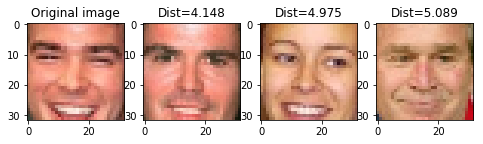

In [34]:
# smiles
show_similar(X_test[247])

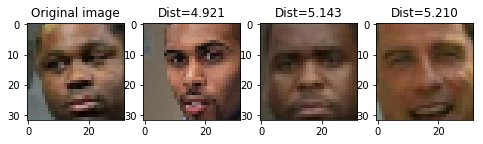

In [35]:
# ethnicity
show_similar(X_test[56])

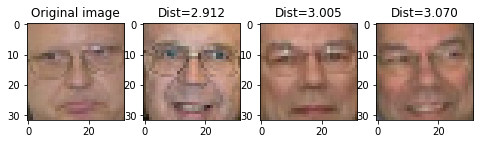

In [36]:
# glasses
show_similar(X_test[63])

# Optional: Cheap image morphing


We can take linear combinations of image codes to produce new images with decoder.

In [0]:
# restore trained encoder weights
s = reset_tf_session()
encoder, decoder = build_deep_autoencoder(IMG_SHAPE, code_size=32)
encoder.load_weights("encoder.h5")
decoder.load_weights("decoder.h5")

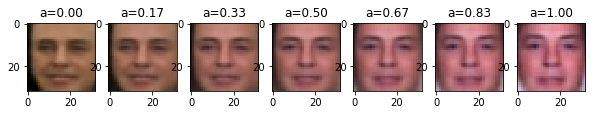

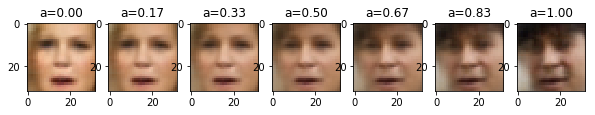

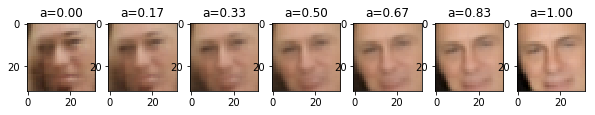

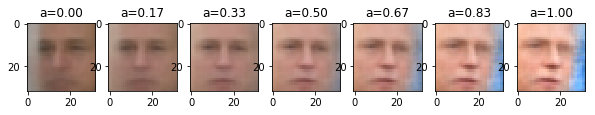

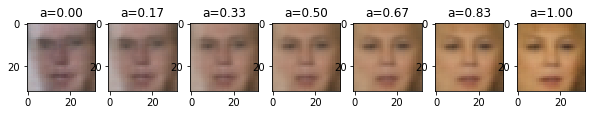

In [38]:
for _ in range(5):
    image1,image2 = X_test[np.random.randint(0,len(X_test),size=2)]

    code1, code2 = encoder.predict(np.stack([image1, image2]))

    plt.figure(figsize=[10,4])
    for i,a in enumerate(np.linspace(0,1,num=7)):

        output_code = code1*(1-a) + code2*(a)
        output_image = decoder.predict(output_code[None])[0]

        plt.subplot(1,7,i+1)
        show_image(output_image)
        plt.title("a=%.2f"%a)
        
    plt.show()

That's it!

Of course there's a lot more you can do with autoencoders.

If you want to generate images from scratch, however, we recommend you our honor track on Generative Adversarial Networks or GANs.